# Affinity Propagation Clustering Technique

Affinity Propagation creates clusters by sending messages between pairs of samples until convergence. **A dataset is then described using a small number of exemplars**, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

## The algorithm

Let $x_1$ through $x_n$ be a set of data points, with no assumptions made about their internal structure, and let $s$ be a function that quantifies the similarity between any two points, such that $s(x_i, x_j) > s(x_i, x_k) \text{ iff } x_i$ is more similar to $x_j$ than to $x_k$. For this example, the negative squared distance of two data points was used i.e. for points xi and xk, 
${\displaystyle s(i,k)=-\left\|x_{i}-x_{k}\right\|^{2}} {\displaystyle s(i,k)=-\left\|x_{i}-x_{k}\right\|^{2}}$

The diagonal of s i.e. ${s(i,i)}$ is particularly important, as it represents the input preference, meaning how likely a particular input is to become an exemplar. When it is set to the same value for all inputs, it controls how many classes the algorithm produces. A value close to the minimum possible similarity produces fewer classes, while a value close to or larger than the maximum possible similarity, produces many classes. It is typically initialized to the median similarity of all pairs of inputs.

The algorithm proceeds by alternating two message passing steps, to update two matrices:

* The "responsibility" matrix *$R$* has values $r(i, k)$ that quantify how well-suited $x_k$ is to serve as the exemplar for $x_i$, relative to other candidate exemplars for $x_i$.

* The "availability" matrix *$A$* contains values $a(i, k)$ that represent how "appropriate" it would be for $x_i$ to pick $x_k$ as its exemplar, taking into account other points' preference for $x_k$ as an exemplar.

Both matrices are initialized to all zeroes, and can be viewed as log-probability tables. The algorithm then performs the following updates iteratively:

First, responsibility updates are sent around: 
$$ {\displaystyle r(i,k)\leftarrow s(i,k)-\max _{k'\neq k}\left\{a(i,k')+s(i,k')\right\}} $$
Then, availability is updated per

$$ {\displaystyle a(i,k)\leftarrow \min \left(0,r(k,k)+\sum _{i'\not \in \{i,k\}}\max(0,r(i',k))\right)} $$ 
for ${\displaystyle i\neq k}$ and
$$ {\displaystyle a(k,k)\leftarrow \sum _{i'\neq k}\max(0,r(i',k))} $$

The iterations are performed until either the cluster boundaries remain unchanged over a number of iterations, or after some predetermined number of iterations. The exemplars are extracted from the final matrices as those whose 'responsibility + availability' for themselves is positive i.e.

$${\displaystyle (r(i,i)+a(i,i))>0} {\displaystyle (r(i,i)+a(i,i))>0})$$

## Pros and cons

Affinity Propagation can be interesting as **it automatically chooses the number of clusters based on the data provided**. For this purpose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

**The main drawback of Affinity Propagation is its complexity**. The algorithm has a time complexity of the order $O(N^2 T)$, where $N$ is the number of samples and $T$ is the number of iterations until convergence. Further, the memory complexity is of the order $O(N^2)$ if a dense similarity matrix is used, but reducible if a sparse similarity matrix is used. This makes Affinity Propagation most appropriate for small to medium sized datasets.

## Make some synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,random_state=0)

In [5]:
X.shape

(300, 2)

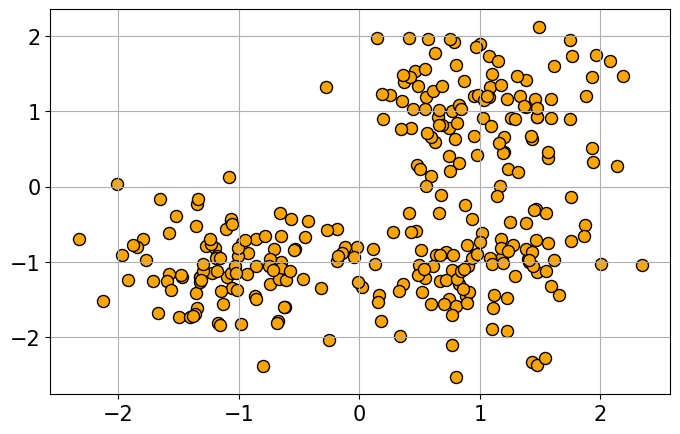

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],edgecolors='k',c='orange',s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Clustering

In [12]:
# Create a custom scoring function using silhouette score
def custom_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Avoid division by zero
    else:
        return silhouette_score(X, labels)

# Define your parameter grid
param_grid = {
    'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
    'preference': [-50, -40, -30, -20, -10]
}

clustering = AffinityPropagation()
grid_search = GridSearchCV(clustering, param_grid, scoring=custom_silhouette_scorer, cv=5)
grid_search.fit(X)

GridSearchCV(cv=5, estimator=AffinityPropagation(),
             param_grid={'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'preference': [-50, -40, -30, -20, -10]},
             scoring=<function custom_silhouette_scorer at 0x000001D94E4CFEE0>)

In [14]:
best_clustering = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_clustering, best_params, best_score

(AffinityPropagation(preference=-10),
 {'damping': 0.5, 'preference': -10},
 0.5550626752141137)

In [15]:
# Compute Affinity Propagation
af_model = AffinityPropagation(preference=-10, damping=0.5).fit(X)
cluster_centers_indices = af_model.cluster_centers_indices_
labels = af_model.labels_
n_clusters_ = len(cluster_centers_indices)

#### Number of detected clusters and their centers

In [16]:
print("Number of clusters detected by the algorithm:", n_clusters_)

Number of clusters detected by the algorithm: 8


In [17]:
print("Cluster centers detected at:\n\n", X[cluster_centers_indices])

Cluster centers detected at:

 [[-1.35980219 -1.40649649]
 [ 1.5940149   1.15847131]
 [ 1.17589006 -0.81038223]
 [ 0.95077374  0.66826086]
 [ 0.70067303 -1.55794849]
 [-1.35235014 -0.52836964]
 [-0.54491055 -0.84139089]
 [ 0.54358889  1.55850814]]


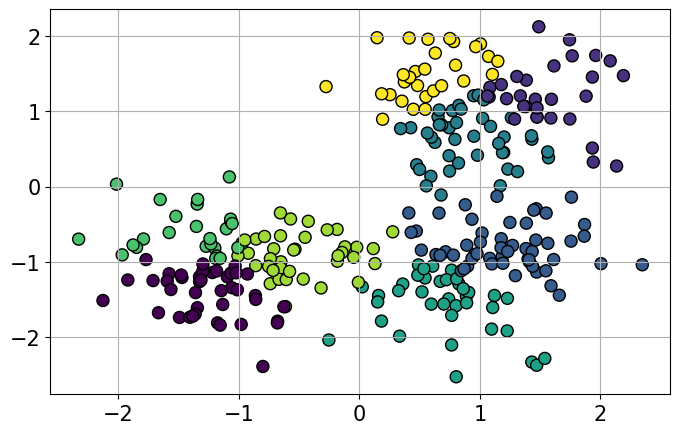

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],edgecolors='k',c=af_model.labels_,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Homogeneity

Homogeneity metric of a cluster labeling given a ground truth.

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

On the other hand, the homogeneity score measures how well the clustering algorithm groups data points that belong to the same category together. It answers the question, "Does the algorithm create clusters where all the animals in each group are of the same species?"

In [19]:
print ("Homogeneity score:", metrics.homogeneity_score(labels_true,labels))

Homogeneity score: 0.8924923438472772


#### Completeness

Completeness metric of a cluster labeling given a ground truth.

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

Think of the completeness score as a measure of whether the clustering algorithm captures all members of the same group or category. It answers the question, "Does the algorithm make sure that all the animals of the same species are in one cluster?"

In [20]:
print("Completeness score:",metrics.completeness_score(labels_true,labels))

Completeness score: 0.477109967627339


In essence, completeness focuses on making sure that no data points from a single category are left out, while homogeneity concentrates on how well the algorithm groups similar data points together within clusters. Both scores aim to assess the quality of the clustering results, but they do so from slightly different angles:

Completeness Score: Is aboutcapturing all data points from the same category.

Homogeneity Score: Is about ensuring that clusters contain only data points from the same category.
    
A good clustering result will have high scores for both completeness and homogeneity, indicating that it successfully captures and groups data points based on their true categories.

#### Prediction

In [21]:
x_new = [0.5,0.4]
x_pred = af_model.predict([x_new])[0]

In [22]:
print("New point ({},{}) will belong to cluster {}".format(x_new[0],x_new[1],x_pred))

New point (0.5,0.4) will belong to cluster 3


In [23]:
x_new = [-0.5,0.4]
x_pred = af_model.predict([x_new])[0]

In [24]:
print("New point ({},{}) will belong to cluster {}".format(x_new[0],x_new[1],x_pred))

New point (-0.5,0.4) will belong to cluster 6


## Time complexity and model quality as the data size grows

In [25]:
import time
from tqdm import tqdm 

In [26]:
n_samples = [10,20,50,100,200,500,1000,2000,3000,5000,7500,10000]
centers = [[1, 1], [-1, -1], [1, -1]]
t_aff = []
homo_aff=[]
complete_aff=[]

for i in tqdm(n_samples):
    X,labels_true = make_blobs(n_samples=i, centers=centers, cluster_std=0.5,random_state=0)
    t1 = time.time()
    af_model = AffinityPropagation(preference=-50,max_iter=50).fit(X)
    t2=time.time()
    t_aff.append(t2-t1)
    homo_aff.append(metrics.homogeneity_score(labels_true,af_model.labels_))
    complete_aff.append(metrics.completeness_score(labels_true,af_model.labels_))

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
 50%|█████████████████████████████████████████▌                                         | 6/12 [00:00<00:00, 31.93it/s]C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\s

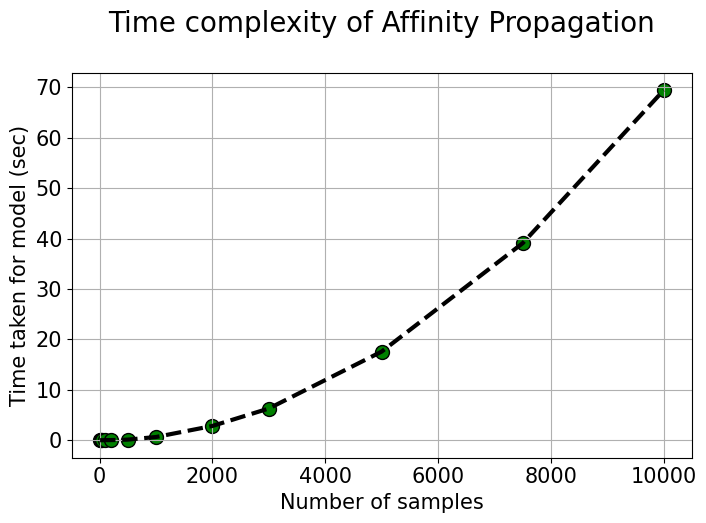

In [27]:
plt.figure(figsize=(8,5))
plt.title("Time complexity of Affinity Propagation\n",fontsize=20)
plt.scatter(n_samples,t_aff,edgecolors='k',c='green',s=100)
plt.plot(n_samples,t_aff,'k--',lw=3)
plt.grid(True)
plt.xticks(fontsize=15)
plt.xlabel("Number of samples",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Time taken for model (sec)",fontsize=15)
plt.show()

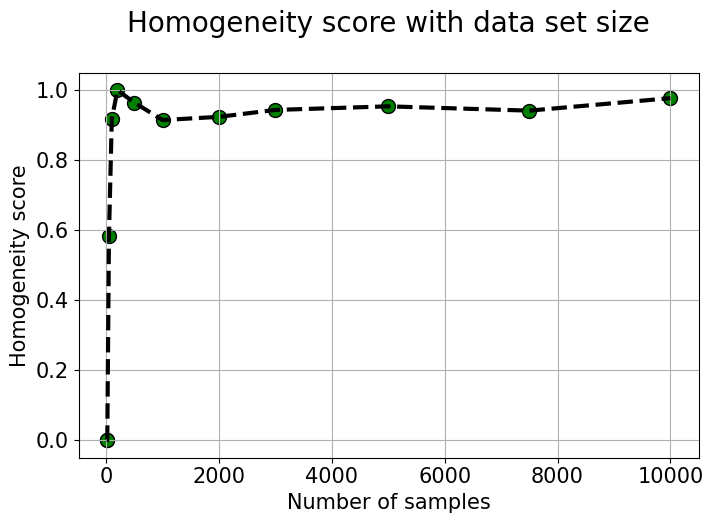

In [28]:
plt.figure(figsize=(8,5))
plt.title("Homogeneity score with data set size\n",fontsize=20)
plt.scatter(n_samples,homo_aff,edgecolors='k',c='green',s=100)
plt.plot(n_samples,homo_aff,'k--',lw=3)
plt.grid(True)
plt.xticks(fontsize=15)
plt.xlabel("Number of samples",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Homogeneity score",fontsize=15)
plt.show()

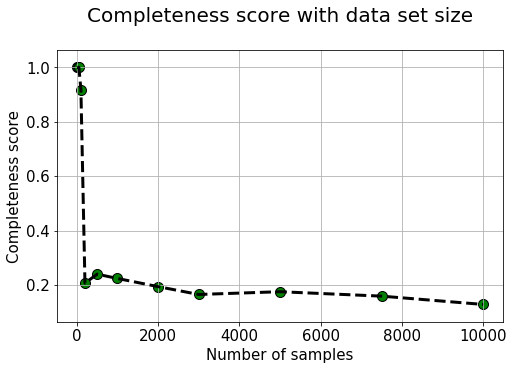

In [20]:
plt.figure(figsize=(8,5))
plt.title("Completeness score with data set size\n",fontsize=20)
plt.scatter(n_samples,complete_aff,edgecolors='k',c='green',s=100)
plt.plot(n_samples,complete_aff,'k--',lw=3)
plt.grid(True)
plt.xticks(fontsize=15)
plt.xlabel("Number of samples",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Completeness score",fontsize=15)
plt.show()

## How well the cluster detection works in the presence of noise? Can damping help?

Create data sets with varying degree of noise std. dev and run the model to detect clusters. Also, play with damping parameter to see the effect.

In [33]:
make_blobs(n_samples=200, centers=centers, cluster_std=i,random_state=101)

(array([[-6.92678332e-01, -6.64723512e-01],
        [ 1.33380927e+00,  1.36900372e+00],
        [ 2.17714584e-01, -4.27054024e-01],
        [-3.03633649e+00,  2.48024411e+00],
        [ 6.41369968e+00,  2.25626542e+00],
        [-3.61296461e+00, -4.26584799e+00],
        [ 9.68050472e-01, -3.86626118e+00],
        [ 2.92291631e+00, -3.28242458e+00],
        [-5.42657209e-01,  1.22095482e+00],
        [-3.12921627e-01, -6.07449368e-01],
        [ 7.28329756e-01, -4.12186289e+00],
        [-6.29042025e-01, -2.98803658e+00],
        [ 1.08254435e-01,  3.71747530e-01],
        [ 2.17686746e-01,  3.05658632e+00],
        [-2.42992521e+00,  1.70009158e+00],
        [ 7.66453367e-01,  4.80350959e+00],
        [ 2.30223590e+00,  3.61363911e-01],
        [-1.76020700e+00, -4.33211836e+00],
        [ 1.91868614e+00,  1.71025366e-01],
        [ 1.37424904e+00, -4.65690295e-01],
        [ 1.46321833e+00, -6.89176216e-01],
        [ 6.36192621e-01, -2.20647093e+00],
        [-1.01037383e+00, -4.835

In [29]:
noise = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0]
n_clusters = []
for i in noise:
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, labels_true = make_blobs(n_samples=200, centers=centers, cluster_std=i,random_state=101)
    af_model=AffinityPropagation(preference=-50,max_iter=500,convergence_iter=15,damping=0.5).fit(X)
    n_clusters.append(len(af_model.cluster_centers_indices_))  

C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\User\anaconda3\envs\nlp_2\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Detected number of clusters: [200, 200, 150, 46, 3, 3, 3, 3, 4, 4, 5, 6, 6, 7, 9, 9]


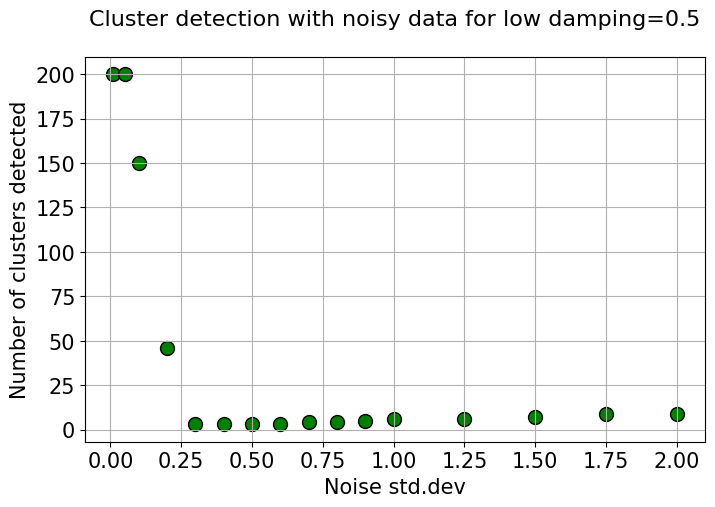

In [30]:
print("Detected number of clusters:",n_clusters)
plt.figure(figsize=(8,5))
plt.title("Cluster detection with noisy data for low damping=0.5\n",fontsize=16)
plt.scatter(noise,n_clusters,edgecolors='k',c='green',s=100)
plt.grid(True)
plt.xticks(fontsize=15)
plt.xlabel("Noise std.dev",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Number of clusters detected",fontsize=15)
plt.show()

In [31]:
noise = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0]
n_clusters = []
for i in noise:
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, labels_true = make_blobs(n_samples=200, centers=centers, cluster_std=i,random_state=101)
    af_model=AffinityPropagation(preference=-50,max_iter=500,convergence_iter=15,damping=0.9).fit(X)
    n_clusters.append(len(af_model.cluster_centers_indices_))  

Detected number of clusters: [3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6, 7]


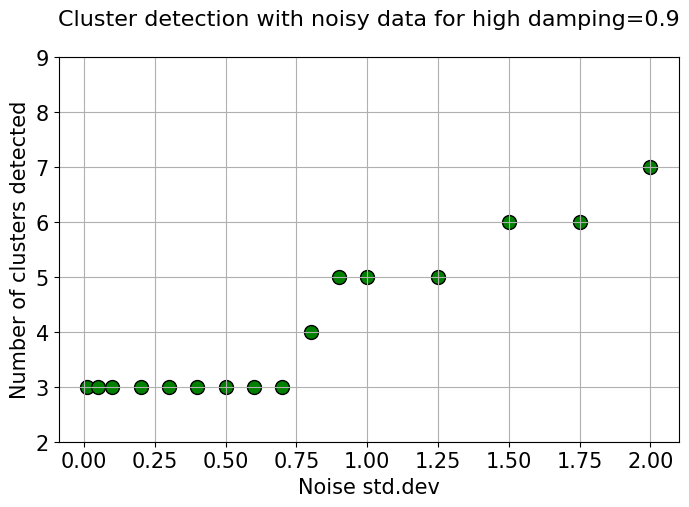

In [32]:
print("Detected number of clusters:",n_clusters)
plt.figure(figsize=(8,5))
plt.title("Cluster detection with noisy data for high damping=0.9\n",fontsize=16)
plt.scatter(noise,n_clusters,edgecolors='k',c='green',s=100)
plt.grid(True)
plt.xticks(fontsize=15)
plt.xlabel("Noise std.dev",fontsize=15)
plt.yticks([i for i in range(2,10)],fontsize=15)
plt.ylabel("Number of clusters detected",fontsize=15)
plt.show()

** We see that for low damping factor is not good for cluster detection as it creates oscillatory predictions. Higher damping stablizes the prediction. For low noise std. dev, the prediction is correct and for higher noise it deviates slowly.**